In [1]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

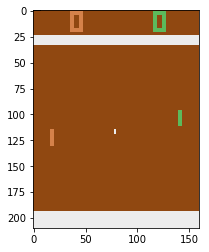

In [2]:
env = gym.make("Pong-v0") # environment info
observation = env.reset()

for i in range(22):
    # The ball is released after 20 frames
    if i > 20:
        plt.imshow(observation)
        plt.show()
    
    # Get the next observation
    observation, _, _, _ = env.step(1)

In [3]:
def preprocess_frame(frame):
    # remove top part of frame and some background
    frame = frame[35:195, 10:150]
    
    # grayscale frame and downsize by factor 2
    frame = frame[::2, ::2, 0]
    
    # set background to 0
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    
    # set ball and paddles to 1
    frame[frame != 0] = 1
    return frame.astype(np.float).ravel()

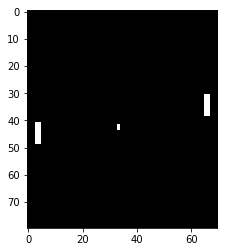

In [4]:
obs_preprocessed = preprocess_frame(observation).reshape(80, 70)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

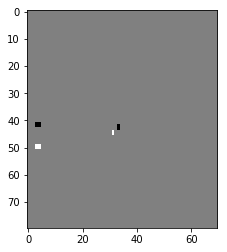

In [5]:
observation_next, _, _, _ = env.step(1)
diff = preprocess_frame(observation_next) - preprocess_frame(observation)
plt.imshow(diff.reshape(80, 70), cmap='gray')
plt.show()

In [6]:
input_dim = 80*70
hidden_L1 = 400
hidden_L2 = 200
actions = [1, 2, 3]
n_actions = len(actions)

model = {}
with tf.variable_scope('L1',reuse=False):
    init_W1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(input_dim), dtype=tf.float32)
    model['W1'] = tf.get_variable("W1", [input_dim, hidden_L1], initializer=init_W1)

with tf.variable_scope('L2',reuse=False):
    init_W2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(hidden_L1), dtype=tf.float32)
    model['W2'] = tf.get_variable("W2", [hidden_L1, n_actions], initializer=init_W2)

In [7]:
def policy_forward(x):
    x = tf.matmul(x, model['W1'])
    x = tf.nn.relu(x)
    x = tf.matmul(x, model['W2'])
    p = tf.nn.softmax(x)
    return p

In [8]:
def discounted_rewards(reward, gamma):
    discounted_function = lambda a, v: a*gamma + v;
    reward_reverse = tf.scan(discounted_function, tf.reverse(reward, [True, False]))
    discounted_reward = tf.reverse(reward_reverse, [True, False])
    return discounted_reward

In [9]:
learning_rate = 0.001
decay_rate = 0.99
gamma = 0.99
batch_size = 10

In [12]:
# TensorFlow placeholders
episode_x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
episode_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions])
episode_reward = tf.placeholder(dtype=tf.float32, shape=[None, 1])

episode_discounted_reward = discounted_rewards(episode_reward)
episode_mean, episode_variance= tf.nn.moments(episode_discounted_reward, [0], shift=None)
# Normalize discounted reward
episode_discounted_reward -= episode_mean
episode_discounted_reward /= tf.sqrt(episode_variance + 1e-6)

# Optimizer settings
tf_aprob = policy_forward(episode_x)
loss = tf.nn.l2_loss(episode_y - tf_aprob)
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=episode_discounted_reward)
train_op = optimizer.apply_gradients(gradients)

# Initialize graph
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Settings to save the trained model
saver = tf.train.Saver(tf.global_variables())
save_path = 'checkpoints/pong_rl.ckpt'

In [13]:
obs_prev = None
xs, ys, rs, = [], [], []
reward_sum = 0
episode_number = 0
reward_window = None
reward_best = -22
history = []

observation = env.reset()
while True:
# if True: env.render() # uncomment if you want to see the agent play while training

    # Preprocess the observation, set input to network to be difference image
    obs_cur = preprocess_frame(observation)
    obs_diff = obs_cur - obs_prev if obs_prev is not None else np.zeros(input_dim)
    obs_prev = obs_cur

    # Sample an action (policy)
    feed = {episode_x: np.reshape(obs_diff, (1,-1))}
    aprob = sess.run(tf_aprob, feed) ; aprob = aprob[0,:]
    action = np.random.choice(n_actions, p=aprob)
    label = np.zeros_like(aprob) ; label[action] = 1

    # Return action to environment and extract next observation, reward, and status
    observation, reward, done, info = env.step(action+1)
    reward_sum += reward
    
    # record game history
    xs.append(obs_diff) ; ys.append(label) ; rs.append(reward)

    if done:
        history.append(reward_sum)
        reward_window = -21 if reward_window is None else np.mean(history[-100:])
        
        # Update the weights with the stored values (update policies)
        feed = {episode_x: np.vstack(xs), episode_y: np.vstack(ys), episode_reward: np.vstack(rs), }
        _ = sess.run(train_op, feed)
        
        print('episode {:2d}: reward: {:2.0f}'.format(episode_number, reward_sum))
        
        xs, ys, rs = [], [], []
        episode_number += 1
        observation = env.reset()
        reward_sum = 0
        
        # Save best model after every 10 episodes
        if (episode_number % 10 == 0) & (reward_window > reward_best):
            saver.save(sess, save_path, global_step=episode_number)
            reward_best = reward_window
            print("Save best model {:2d}: {:2.5f} (reward window)".format(episode_number, reward_window))

episode  0: reward: -21
episode  1: reward: -21
episode  2: reward: -21
episode  3: reward: -18
episode  4: reward: -20
episode  5: reward: -21
episode  6: reward: -20
episode  7: reward: -21
episode  8: reward: -21
episode  9: reward: -20
Save best model 10: -20.40000 (reward window)
episode 10: reward: -20
episode 11: reward: -19
episode 12: reward: -21
episode 13: reward: -20
episode 14: reward: -21
episode 15: reward: -20
episode 16: reward: -19
episode 17: reward: -21
episode 18: reward: -21
episode 19: reward: -21
Save best model 20: -20.35000 (reward window)
episode 20: reward: -21
episode 21: reward: -20
episode 22: reward: -20
episode 23: reward: -20
episode 24: reward: -20
episode 25: reward: -20
episode 26: reward: -21
episode 27: reward: -20
episode 28: reward: -21
episode 29: reward: -21
episode 30: reward: -21
episode 31: reward: -21
episode 32: reward: -19
episode 33: reward: -21
episode 34: reward: -20
episode 35: reward: -20
episode 36: reward: -21
episode 37: reward: 

episode 306: reward: -21
episode 307: reward: -20
episode 308: reward: -20
episode 309: reward: -19
episode 310: reward: -19
episode 311: reward: -21
episode 312: reward: -21
episode 313: reward: -17
episode 314: reward: -20
episode 315: reward: -21
episode 316: reward: -21
episode 317: reward: -20
episode 318: reward: -21
episode 319: reward: -21
episode 320: reward: -20
episode 321: reward: -20
episode 322: reward: -21
episode 323: reward: -20
episode 324: reward: -21
episode 325: reward: -19
episode 326: reward: -19
episode 327: reward: -20
episode 328: reward: -18
episode 329: reward: -20
episode 330: reward: -20
episode 331: reward: -18
episode 332: reward: -21
episode 333: reward: -18
episode 334: reward: -20
episode 335: reward: -20
episode 336: reward: -19
episode 337: reward: -20
episode 338: reward: -21
episode 339: reward: -20
episode 340: reward: -21
episode 341: reward: -18
episode 342: reward: -20
episode 343: reward: -19
episode 344: reward: -20
episode 345: reward: -21


episode 593: reward: -19
episode 594: reward: -19
episode 595: reward: -19
episode 596: reward: -20
episode 597: reward: -18
episode 598: reward: -17
episode 599: reward: -17
Save best model 600: -18.17000 (reward window)
episode 600: reward: -15
episode 601: reward: -20
episode 602: reward: -20
episode 603: reward: -20
episode 604: reward: -14
episode 605: reward: -17
episode 606: reward: -21
episode 607: reward: -21
episode 608: reward: -20
episode 609: reward: -17
episode 610: reward: -16
episode 611: reward: -21
episode 612: reward: -18
episode 613: reward: -19
episode 614: reward: -19
episode 615: reward: -19
episode 616: reward: -19
episode 617: reward: -17
episode 618: reward: -19
episode 619: reward: -18
episode 620: reward: -16
episode 621: reward: -18
episode 622: reward: -20
episode 623: reward: -15
episode 624: reward: -19
episode 625: reward: -19
episode 626: reward: -18
episode 627: reward: -16
episode 628: reward: -18
episode 629: reward: -14
Save best model 630: -18.070

episode 882: reward: -17
episode 883: reward: -13
episode 884: reward: -8
episode 885: reward: -11
episode 886: reward: -11
episode 887: reward: -13
episode 888: reward: -17
episode 889: reward: -14
Save best model 890: -14.36000 (reward window)
episode 890: reward: -11
episode 891: reward: -13
episode 892: reward: -11
episode 893: reward: -16
episode 894: reward: -12
episode 895: reward: -18
episode 896: reward: -12
episode 897: reward: -13
episode 898: reward: -17
episode 899: reward: -8
Save best model 900: -13.97000 (reward window)
episode 900: reward: -16
episode 901: reward: -15
episode 902: reward: -16
episode 903: reward: -21
episode 904: reward: -15
episode 905: reward: -13
episode 906: reward: -10
episode 907: reward: -19
episode 908: reward: -5
episode 909: reward: -4
episode 910: reward: -15
episode 911: reward: -9
episode 912: reward: -14
episode 913: reward: -12
episode 914: reward: -13
episode 915: reward: -14
episode 916: reward: -18
episode 917: reward: -17
episode 918

episode 1184: reward: -20
episode 1185: reward: -10
episode 1186: reward: -16
episode 1187: reward: -13
episode 1188: reward: -13
episode 1189: reward: -8
Save best model 1190: -11.67000 (reward window)
episode 1190: reward: -10
episode 1191: reward: -16
episode 1192: reward: -13
episode 1193: reward: -13
episode 1194: reward: -11
episode 1195: reward: -5
episode 1196: reward: -13
episode 1197: reward: -12
episode 1198: reward: -9
episode 1199: reward: -8
Save best model 1200: -11.30000 (reward window)
episode 1200: reward: -15
episode 1201: reward: -6
episode 1202: reward: -13
episode 1203: reward: -8
episode 1204: reward: -4
episode 1205: reward: -3
episode 1206: reward: -11
episode 1207: reward: -7
episode 1208: reward: -11
episode 1209: reward: -17
Save best model 1210: -11.05000 (reward window)
episode 1210: reward: -15
episode 1211: reward: -15
episode 1212: reward: -4
episode 1213: reward: -9
episode 1214: reward: -19
episode 1215: reward: -13
episode 1216: reward: -17
episode 1

episode 1487: reward: -13
episode 1488: reward: -2
episode 1489: reward: -12
episode 1490: reward: -2
episode 1491: reward:  4
episode 1492: reward: -15
episode 1493: reward: -17
episode 1494: reward: -14
episode 1495: reward: -15
episode 1496: reward: -15
episode 1497: reward: -8
episode 1498: reward: -12
episode 1499: reward: -10
episode 1500: reward: -17
episode 1501: reward: -9
episode 1502: reward: -10
episode 1503: reward: -9
episode 1504: reward: -15
episode 1505: reward: -13
episode 1506: reward: -10
episode 1507: reward: -5
episode 1508: reward: -3
episode 1509: reward: -12
episode 1510: reward: -11
episode 1511: reward: -4
episode 1512: reward: -10
episode 1513: reward: -13
episode 1514: reward: -17
episode 1515: reward: -13
episode 1516: reward: -10
episode 1517: reward: -9
episode 1518: reward: -9
episode 1519: reward: -8
episode 1520: reward: -12
episode 1521: reward:  9
episode 1522: reward: -9
episode 1523: reward: -12
episode 1524: reward: -2
episode 1525: reward: -5
ep

episode 1802: reward: -2
episode 1803: reward: -11
episode 1804: reward: -7
episode 1805: reward: -9
episode 1806: reward: -12
episode 1807: reward: -7
episode 1808: reward: -3
episode 1809: reward: -12
episode 1810: reward: -16
episode 1811: reward: -15
episode 1812: reward: -9
episode 1813: reward: -17
episode 1814: reward: -15
episode 1815: reward: -9
episode 1816: reward: -9
episode 1817: reward: -13
episode 1818: reward: -2
episode 1819: reward: -6
episode 1820: reward: -4
episode 1821: reward: -11
episode 1822: reward: -8
episode 1823: reward: -2
episode 1824: reward:  2
episode 1825: reward: -8
episode 1826: reward: -11
episode 1827: reward: -11
episode 1828: reward: -19
episode 1829: reward: -15
episode 1830: reward: -7
episode 1831: reward: -9
episode 1832: reward: -8
episode 1833: reward: -6
episode 1834: reward: -9
episode 1835: reward: -7
episode 1836: reward: -11
episode 1837: reward: -11
episode 1838: reward: -13
episode 1839: reward: -9
episode 1840: reward: -12
episode 

episode 2115: reward: -2
episode 2116: reward: -11
episode 2117: reward: -9
episode 2118: reward: -11
episode 2119: reward: -13
Save best model 2120: -8.28000 (reward window)
episode 2120: reward: -6
episode 2121: reward: -7
episode 2122: reward: -5
episode 2123: reward: -9
episode 2124: reward: -12
episode 2125: reward: -7
episode 2126: reward: -13
episode 2127: reward: -7
episode 2128: reward: -11
episode 2129: reward: -15
Save best model 2130: -8.02000 (reward window)
episode 2130: reward: -7
episode 2131: reward: -8
episode 2132: reward: -2
episode 2133: reward: -6
episode 2134: reward: -8
episode 2135: reward:  1
episode 2136: reward: -11
episode 2137: reward: -11
episode 2138: reward: -5
episode 2139: reward: -17
Save best model 2140: -7.77000 (reward window)
episode 2140: reward: -8
episode 2141: reward: -14
episode 2142: reward: -5
episode 2143: reward: -7
episode 2144: reward: -1
episode 2145: reward: -7
episode 2146: reward: -8
episode 2147: reward: -14
episode 2148: reward: 

episode 2417: reward: -7
episode 2418: reward: -10
episode 2419: reward: -6
episode 2420: reward: -5
episode 2421: reward: -3
episode 2422: reward: -11
episode 2423: reward: -7
episode 2424: reward: -13
episode 2425: reward: -2
episode 2426: reward: -7
episode 2427: reward: -13
episode 2428: reward: -10
episode 2429: reward: -10
episode 2430: reward: -11
episode 2431: reward: -8
episode 2432: reward: -14
episode 2433: reward: -13
episode 2434: reward: -12
episode 2435: reward: -9
episode 2436: reward: -15
episode 2437: reward: -4
episode 2438: reward: -13
episode 2439: reward: -13
episode 2440: reward: -6
episode 2441: reward: -12
episode 2442: reward: -9
episode 2443: reward: -10
episode 2444: reward: -5
episode 2445: reward: -11
episode 2446: reward: -13
episode 2447: reward: -18
episode 2448: reward: -13
episode 2449: reward: -16
episode 2450: reward:  7
episode 2451: reward: -3
episode 2452: reward: -2
episode 2453: reward: -13
episode 2454: reward: -5
episode 2455: reward: -8
epis

KeyboardInterrupt: 

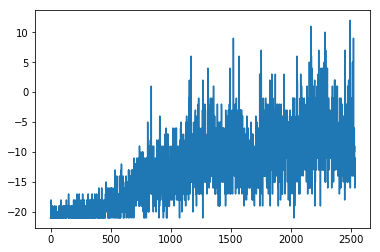

In [14]:
plt.plot(history)
plt.show()

In [ ]:
observation = env.reset()
while True:
    if True: env.render()

    # Preprocess the observation, set input to network to be difference image
    obs_cur = preprocess_frame(observation)
    obs_diff = obs_cur - obs_prev if obs_prev is not None else np.zeros(input_dim)
    obs_prev = obs_cur

    # Sample an action (policy)
    feed = {tf_x: np.reshape(obs_diff, (1,-1))}
    aprob = sess.run(tf_aprob, feed) ; aprob = aprob[0,:]
    action = np.random.choice(n_actions, p=aprob)
    label = np.zeros_like(aprob) ; label[action] = 1

    # Return action to environment and extract next observation, reward, and status
    observation, reward, done, info = env.step(action+1)
    
    if done: observation = env.reset()